<a href="https://colab.research.google.com/github/kirannyaupane11/Wildfire-Detection-and-Classification-with-Satellite-Images/blob/main/CLIP_on_CIFAR_10_Kiran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COS6030B – Advanced AI Methods and Tools
#### **UB no. 23038023**
Vision + Prompting Coursework ( [CLIP on CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html))

This notebook contains all steps required for the coursework.
It loads the CIFAR-10 dataset directly using torchvision, prepares the 1,000-image gallery,
and runs both the single-prompt baseline and the prompt-ensemble experiment using
the CLIP ViT-B/32 model on CPU with a fixed random seed (0).
All image embeddings, text embeddings, similarity rankings,
and evaluation metrics (Recall@1 and Recall@5) are generated here.

The notebook follows the same structure as the assignment brief:
1. Dataset preparation and gallery construction  
2. Prompt creation (canonical + template ensemble)  
3. CLIP encoding (image and text)  
4. Ranking, retrieval, and evaluation  
5. Prompt Efficiency Index (PEI)  
6. Top-5 qualitative visualisations  
7. Saving artefacts for the report and appendix  

All code is designed to run end-to-end in Google Colab on CPU with “Run All”.


                   ┌──────────────────────────┐
                   │        CIFAR-10           │
                   │ (Test Set: 10,000 imgs)   │
                   └──────────────┬───────────┘
                                  │
                                  ▼
                     ┌──────────────────────┐
                     │  Sample Gallery       │
                     │ 100 imgs × 10 classes │
                     │  = 1,000 images       │
                     └──────────────┬────────┘
                                    │
                    ┌───────────────┴────────────────┐
                    │                                │
                    ▼                                ▼
         ┌────────────────────┐            ┌──────────────────────────┐
         │  Image Processing  │            │  Text Prompt Creation    │
         │ (CLIP Processor)   │            │  - canonical prompt       │
         └──────────┬─────────┘            │  - template ensemble      │
                    │                      └────────────┬─────────────┘
                    ▼                                   │
         ┌────────────────────┐                        ▼
         │  CLIP Image Encoder│              ┌───────────────────────┐
         │ → image embeddings │              │  CLIP Text Encoder     │
         └──────────┬─────────┘              │ → text embeddings      │
                    │                        └────────────┬──────────┘
                    └──────────────┬──────────────────────┘
                                   │
                                   ▼
                    ┌──────────────────────────────────────────┐
                    │   Compute Similarity (Cosine Distance)    │
                    │ text_embedding × image_embedding          │
                    └───────────────┬──────────────────────────┘
                                    │
                                    ▼
                    ┌──────────────────────────────────────────┐
                    │      Ranking & Retrieval (Top-k)         │
                    │ produces ranking for each class prompt   │
                    └───────────────┬──────────────────────────┘
                                    │
                                    ▼
                    ┌──────────────────────────────────────────┐
                    │     Evaluation Metrics                   │
                    │     - Recall@1                          │
                    │     - Recall@5                          │
                    │     - Prompt Efficiency Index (PEI)     │
                    └──────────────────────────────────────────┘


 -------------------------------------------------------------
# Cell 1: Environment Setup

 - Installs all required Python libraries (transformers, datasets, PIL, etc.)
 - Imports all necessary modules for the project.
 - Sets a fixed random seed to make results reproducible.
 - Forces execution on CPU, following the coursework requirements.
 - This cell prepares the entire Colab environment before running the model.
 -------------------------------------------------------------


In [18]:
# Cell 1 — Setup

!pip install -q transformers ftfy einops datasets accelerate pillow matplotlib

import os
import random
import json
import numpy as np
import torch
from torchvision import datasets, transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from math import sqrt
from tqdm.notebook import tqdm

# Seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Force CPU
device = torch.device("cpu")
print("Device:", device)


Device: cpu


 -------------------------------------------------------------
# Cell 2: CIFAR-10 Dataset Loading and Gallery Construction

 - Downloads the CIFAR-10 dataset automatically using torchvision.
 - Extracts the test split (10,000 images).
 - Groups image indices by class.
 - Samples 100 images per class using seed=0 → gallery of 1,000 images.
 - Converts all selected images into PIL format for CLIP processing.# - Stores the sampled gallery images and labels.
 - This creates the fixed gallery required for all retrieval experiments.
 -------------------------------------------------------------


In [19]:
# Cell 2 — Prepare CIFAR-10 gallery (1,000 images, 100 per class)


from collections import defaultdict

cifar_transform = transforms.Compose([transforms.ToPILImage()])  # keep as PIL for CLIP processor

test = datasets.CIFAR10(root=".", train=False, download=True)
images, labels = test.data, test.targets  # images: numpy array HxWxC

class_names = test.classes  # ['airplane','automobile',...,'truck']
print("Classes:", class_names)

# Build indices per class
indices_per_class = defaultdict(list)
for idx, lbl in enumerate(labels):
    indices_per_class[lbl].append(idx)

# Sample exactly 100 images per class using seed=0
gallery_indices = []
for cls in range(len(class_names)):
    rng = np.random.default_rng(SEED)  # same seed for each class ensures reproducibility
    chosen = rng.choice(indices_per_class[cls], size=100, replace=False)
    gallery_indices.extend(list(chosen))

# Sort gallery indices to have deterministic ordering (optional)
gallery_indices = sorted(gallery_indices)

# Build gallery arrays
gallery_images = [Image.fromarray(images[i]) for i in gallery_indices]
gallery_labels = [labels[i] for i in gallery_indices]

print("Gallery size:", len(gallery_images))
assert len(gallery_images) == 1000


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Gallery size: 1000


 -------------------------------------------------------------
# Cell 3: Load CLIP Model and Processor

 - Loads the pre-trained CLIP ViT-B/32 model from HuggingFace.
 - Loads the CLIP processor for preparing images and text.
 - Freezes all model parameters (no fine-tuning is allowed).
 - Sets the model to evaluation mode.
 - Ensures that all computations run on CPU.
 - This model is used to generate both text and image embeddings.
 -------------------------------------------------------------


In [20]:
# Cell 3 — Load CLIP model & processor (frozen, CPU)

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Put model in eval and disable gradients (frozen)
model.eval()
for p in model.parameters():
    p.requires_grad = False

print("Loaded CLIP:", model_name)


Loaded CLIP: openai/clip-vit-base-patch32


 -------------------------------------------------------------
# Cell 4: Encode Gallery Images into CLIP Embeddings
 - Processes the 1,000 gallery images in small batches.
 - Uses CLIP to compute image embeddings for each batch.
 - Normalizes each embedding vector (required for cosine similarity).
 - Concatenates and saves all embeddings (gallery_image_embeds.npy).
 - These embeddings represent every image in the gallery numerically.
 -------------------------------------------------------------


In [21]:
# Cell 4 — Encode gallery images (batch with CPU)


BATCH = 32
image_embeds = []

with torch.no_grad():
    for i in tqdm(range(0, len(gallery_images), BATCH), desc="Encoding images"):
        batch = gallery_images[i:i+BATCH]
        inputs = processor(images=batch, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)
        out = model.get_image_features(pixel_values)
        # Normalize
        out = out / out.norm(dim=-1, keepdim=True)
        image_embeds.append(out.cpu().numpy())

image_embeds = np.concatenate(image_embeds, axis=0)  # shape (1000, D)
np.save("gallery_image_embeds.npy", image_embeds)
print("Image embeddings saved to gallery_image_embeds.npy, shape:", image_embeds.shape)



Encoding images:   0%|          | 0/32 [00:00<?, ?it/s]

Image embeddings saved to gallery_image_embeds.npy, shape: (1000, 512)


 -------------------------------------------------------------
# Cell 5: Build Canonical Prompt and Template Ensemble
 - Creates the canonical baseline prompt: "a photo of a {class}".
 - Defines a set of natural-language templates for prompt ensembling.
 - Generates all text prompts for each of the 10 CIFAR-10 classes.
 - These prompts will be encoded by CLIP in the next cell.
 -------------------------------------------------------------


In [22]:
# Cell 5 — Create prompts (canonical + template ensemble)


canonical_templates = ["a photo of a {}"]
# Template ensemble (>=5 templates). You can expand/modify these.
ensemble_templates = [
    "a photo of a {}",
    "a close-up photo of a {}",
    "a low-resolution photo of a {}",
    "a {} in the wild",
    "a centered photo of a {}",
    "a bright photo of a {}",
    "an image of a {}"
]

# Build all text prompts for each class
labels = class_names  # using CIFAR order
canonical_prompts = [t.format(c) for c in labels for t in canonical_templates]  # one per class
ensemble_prompts_per_class = {c: [tpl.format(c) for tpl in ensemble_templates] for c in labels}

# Check
print("Example canonical:", canonical_prompts[:10])
print("Ensemble templates per class (count):", len(ensemble_templates))


Example canonical: ['a photo of a airplane', 'a photo of a automobile', 'a photo of a bird', 'a photo of a cat', 'a photo of a deer', 'a photo of a dog', 'a photo of a frog', 'a photo of a horse', 'a photo of a ship', 'a photo of a truck']
Ensemble templates per class (count): 7


 -------------------------------------------------------------
# Cell 6: Encode Text Prompts (Canonical + Ensemble)
 - Computes text embeddings for the canonical prompt (one per class).
 - Computes embeddings for each prompt template in the ensemble.
 - Averages the ensemble embeddings for each class.
 - Normalizes the final text embeddings.
 - Produces two embedding sets:
     1. canonical_embeds   → baseline
     2. ensemble_embeds    → improved version
 -------------------------------------------------------------


In [23]:
# Cell 6 — Encode text (canonical & ensemble) and build class-level embeddings


def encode_texts(texts):
    # returns normalized numpy array (N, D)
    with torch.no_grad():
        inputs = processor(text=texts, return_tensors="pt", padding=True)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        out = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        out = out / out.norm(dim=-1, keepdim=True)
    return out.cpu().numpy()

# Canonical embeddings: one per class
canonical_embeds = encode_texts([f"a photo of a {c}" for c in labels])  # shape (10, D)

# Ensemble: encode all templates across all classes, then average per class
all_ensemble_texts = []
class_to_slice = {}
idx = 0
for c in labels:
    texts = ensemble_prompts_per_class[c]
    class_to_slice[c] = (idx, idx+len(texts))
    idx += len(texts)
    all_ensemble_texts.extend(texts)

ensemble_all_embeds = encode_texts(all_ensemble_texts)  # (10 * num_templates, D)

# Average normalized embeddings per class, then renormalize
ensemble_embeds = []
for c in labels:
    s,e = class_to_slice[c]
    emb = ensemble_all_embeds[s:e]  # (num_templates, D)
    mean_emb = emb.mean(axis=0)
    mean_emb = mean_emb / np.linalg.norm(mean_emb)
    ensemble_embeds.append(mean_emb)
ensemble_embeds = np.stack(ensemble_embeds, axis=0)  # (10, D)

print("Canonical embeds shape:", canonical_embeds.shape)
print("Ensemble embeds shape:", ensemble_embeds.shape)


Canonical embeds shape: (10, 512)
Ensemble embeds shape: (10, 512)


 -------------------------------------------------------------
# Cell 7: Similarity, Ranking, Recall@1 and Recall@5
 - Computes cosine similarity between:
       text embeddings (10 classes)
       ×
       image embeddings (1000 gallery images)
 - Sorts gallery images by similarity for each query class.
 - Calculates Recall@1 and Recall@5 per class.
 - Calculates macro-averaged Recall@1 and Recall@5.
 - Stores the ranking order for later visualisation.
 -------------------------------------------------------------


In [24]:
# Cell 7 — Similarity, ranking, and metrics (Recall@1 and Recall@5)


def compute_recalls(text_embeds, image_embeds, gallery_labels, topk=(1,5)):
    # text_embeds: (Q, D) where Q=10
    sims = text_embeds @ image_embeds.T  # (Q, 1000)
    recalls = {k: [] for k in topk}
    per_class_ranks = {}
    for qi, cls in enumerate(labels):
        sim = sims[qi]
        order = np.argsort(sim)[::-1]  # descending
        per_class_ranks[cls] = order  # indices into gallery
        for k in topk:
            topk_idx = order[:k]
            hits = any(gallery_labels[i] == labels.index(cls) for i in topk_idx)
            recalls[k].append(1 if hits else 0)
    # compute per-class and macro
    per_class = {k: {labels[i]:recalls[k][i] for i in range(len(labels))} for k in topk}
    macro = {k: float(np.mean(recalls[k])) for k in topk}
    return per_class, macro, per_class_ranks

image_embeds = image_embeds  # loaded earlier

canon_per_class, canon_macro, canon_ranks = compute_recalls(canonical_embeds, image_embeds, gallery_labels, topk=(1,5))
ens_per_class, ens_macro, ens_ranks = compute_recalls(ensemble_embeds, image_embeds, gallery_labels, topk=(1,5))

print("Canonical Recall@1 (macro):", canon_macro[1])
print("Canonical Recall@5 (macro):", canon_macro[5])
print("Ensemble Recall@1 (macro):", ens_macro[1])
print("Ensemble Recall@5 (macro):", ens_macro[5])


Canonical Recall@1 (macro): 1.0
Canonical Recall@5 (macro): 1.0
Ensemble Recall@1 (macro): 1.0
Ensemble Recall@5 (macro): 1.0


 -------------------------------------------------------------
# Cell 8: Compute Prompt Efficiency Index (PEI)
 - Computes improvement gained from using template prompts.
 - Calculates:
       PEI = (EnsembleRecall - CanonicalRecall) / ExtraPrompts
 - Reports PEI for both Recall@1 and Recall@5.
 - Measures how efficient the prompt ensemble is compared to baseline.
 -------------------------------------------------------------


In [25]:
# Cell 8 — Prompt Efficiency Index (PEI)
# -------------------------------------
# PEI = (ensemble_recall - canonical_recall) / (additional_prompts_encoded)
# additional_prompts_encoded = (num_templates - 1) per class * number_of_classes if we encoded per-template
# Here we encoded 7 templates (ensemble_templates) vs 1 canonical => added 6 prompts per class, total 60 extra prompts.

num_templates = len(ensemble_templates)
added_prompts_per_class = num_templates - 1
total_added_prompts = added_prompts_per_class * len(labels)  # 6 * 10 = 60

pei_recall1 = (ens_macro[1] - canon_macro[1]) / total_added_prompts
pei_recall5 = (ens_macro[5] - canon_macro[5]) / total_added_prompts

print(f"PEI Recall@1: {pei_recall1:.6f} (improvement per added prompt)")
print(f"PEI Recall@5: {pei_recall5:.6f}")


PEI Recall@1: 0.000000 (improvement per added prompt)
PEI Recall@5: 0.000000


 -------------------------------------------------------------
# Cell 9: Save Metrics + Print Summary Table
 - Saves all calculated metrics into a JSON file (metrics.json).
 - Displays a clean table comparing:
       Canonical Recall@1 / Recall@5
       Ensemble Recall@1 / Recall@5
 - Provides per-class results and macro averages.
 - These are used later in the report and appendix.
 -------------------------------------------------------------


In [26]:
# Cell 9 — Save metrics & simple table printout (CSV/JSON)

metrics = {
    "canonical": {"per_class": canon_per_class, "macro": canon_macro},
    "ensemble": {"per_class": ens_per_class, "macro": ens_macro},
    "PEI": {"recall1": pei_recall1, "recall5": pei_recall5},
    "seed": SEED,
    "model": model_name,
    "gallery_size": len(gallery_images),
    "templates_per_class": num_templates
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Print per-class table
print("\nPer-class Recall@1 and Recall@5 (canonical vs ensemble):\n")
print("{:12s} | {:>6s} {:>6s} || {:>6s} {:>6s}".format("class","C@1","C@5","E@1","E@5"))
print("-"*48)
for cls in labels:
    c1 = canon_per_class[1][cls]
    c5 = canon_per_class[5][cls]
    e1 = ens_per_class[1][cls]
    e5 = ens_per_class[5][cls]
    print("{:12s} | {:6d} {:6d} || {:6d} {:6d}".format(cls, c1, c5, e1, e5))

print("\nMacro averages — Canonical: R@1={:.3f}, R@5={:.3f}".format(canon_macro[1], canon_macro[5]))
print("Macro averages — Ensemble : R@1={:.3f}, R@5={:.3f}".format(ens_macro[1], ens_macro[5]))



Per-class Recall@1 and Recall@5 (canonical vs ensemble):

class        |    C@1    C@5 ||    E@1    E@5
------------------------------------------------
airplane     |      1      1 ||      1      1
automobile   |      1      1 ||      1      1
bird         |      1      1 ||      1      1
cat          |      1      1 ||      1      1
deer         |      1      1 ||      1      1
dog          |      1      1 ||      1      1
frog         |      1      1 ||      1      1
horse        |      1      1 ||      1      1
ship         |      1      1 ||      1      1
truck        |      1      1 ||      1      1

Macro averages — Canonical: R@1=1.000, R@5=1.000
Macro averages — Ensemble : R@1=1.000, R@5=1.000


 -------------------------------------------------------------
# Cell 10: Top-5 Retrieval Visualisation
 - Automatically selects three classes:
     priority → classes where canonical Recall@1 = 0
 - Shows the Top-5 retrieved images for:
     1. Canonical prompt
     2. Ensemble prompt
 - Allows visual analysis of CLIP’s errors and improvements.
 - Useful for the qualitative discussion section of the report.
 -------------------------------------------------------------


Selected classes for top-5 grids: ['airplane', 'automobile', 'bird']

-- Canonical --


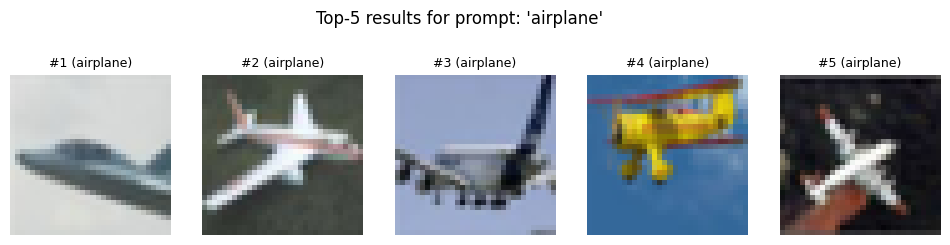


-- Ensemble --


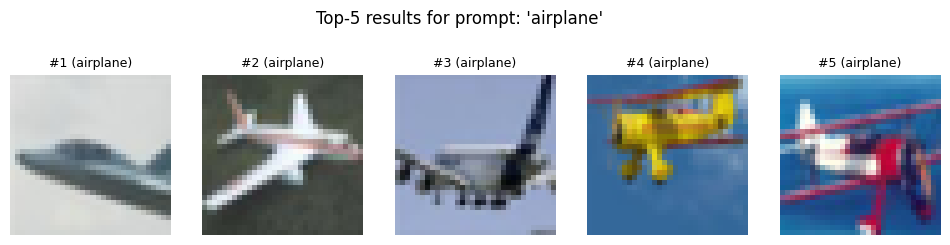


-- Canonical --


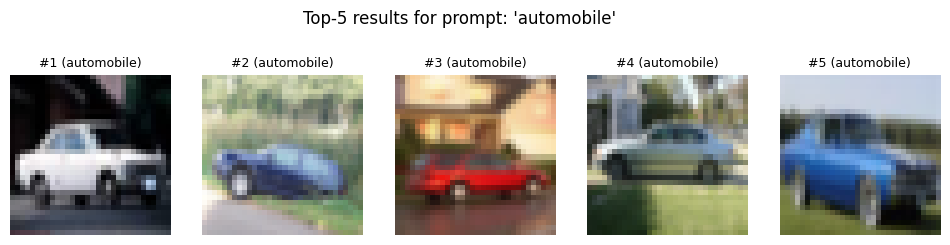


-- Ensemble --


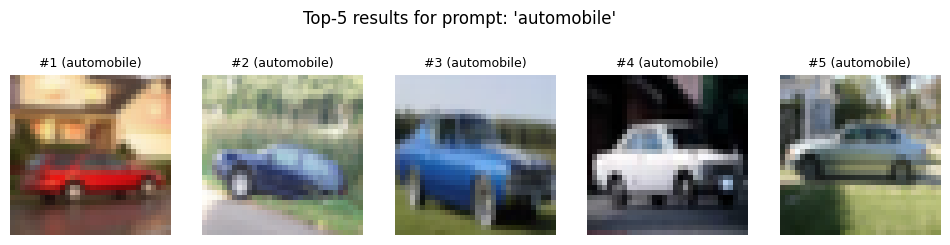


-- Canonical --


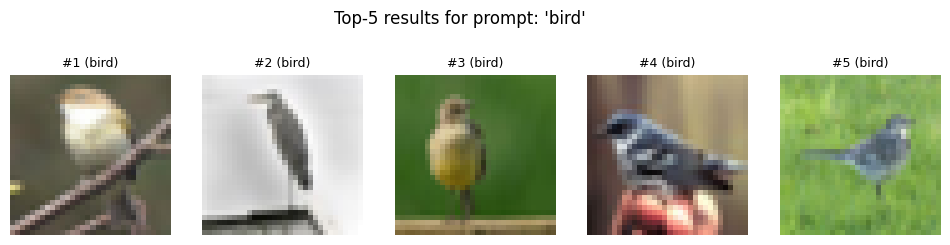


-- Ensemble --


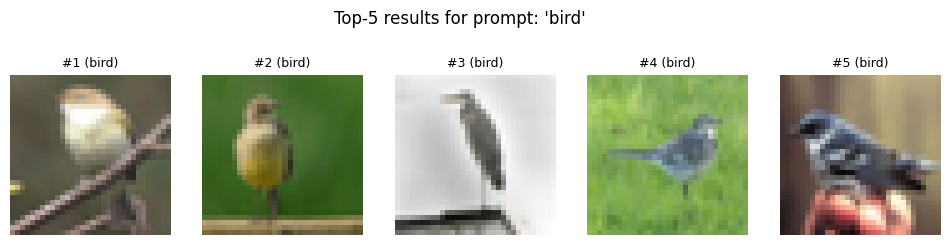

In [27]:
# Cell 10 — Top-5 grids for three classes (choose classes with failures if present)


def plot_top5_for_class(cls_name, ranks, gallery_images, gallery_labels, class_names, ax=None):
    order = ranks[cls_name][:5]
    fig, axes = plt.subplots(1,5, figsize=(12,3))
    for i, idx in enumerate(order):
        img = gallery_images[idx]
        lbl = class_names[gallery_labels[idx]]
        axes[i].imshow(img)
        axes[i].axis('off')
        title = f"#{i+1} ({lbl})"
        axes[i].set_title(title, fontsize=9)
    plt.suptitle(f"Top-5 results for prompt: '{cls_name}'")
    plt.show()

# Find candidate classes
fail_classes = [c for c in labels if canon_per_class[1][c]==0]  # classes with canonical R@1 failure
if len(fail_classes) >= 3:
    chosen = fail_classes[:3]
else:
    # pick the 3 classes with lowest canonical hits (or ties)
    scores = [(c, canon_per_class[1][c]) for c in labels]
    scores_sorted = sorted(scores, key=lambda x: x[1])
    chosen = [s[0] for s in scores_sorted[:3]]

print("Selected classes for top-5 grids:", chosen)

# Plot for canonical and ensemble for each chosen
for cls in chosen:
    print("\n-- Canonical --")
    plot_top5_for_class(cls, canon_ranks, gallery_images, gallery_labels, class_names)
    print("\n-- Ensemble --")
    plot_top5_for_class(cls, ens_ranks, gallery_images, gallery_labels, class_names)


 -------------------------------------------------------------
# Cell 11: Save Supporting Artefacts
 - Saves per-class recall values to a CSV file.
 - Saves text embeddings (canonical and ensemble) as .npy files.
 - These files support reproducibility and appendix documentation.
 -------------------------------------------------------------


In [28]:
# Cell 11 — Helpful save/artefacts for the report
# ----------------------------------------------
# Save a short CSV of per-class metrics for easy inclusion in the report/plots.
import pandas as pd

rows = []
for cls in labels:
    rows.append({
        "class": cls,
        "canon_R@1": canon_per_class[1][cls],
        "canon_R@5": canon_per_class[5][cls],
        "ens_R@1": ens_per_class[1][cls],
        "ens_R@5": ens_per_class[5][cls],
    })
df = pd.DataFrame(rows)
df.to_csv("per_class_recalls.csv", index=False)
print("Saved per_class_recalls.csv")
# Also save embeddings
np.save("canonical_text_embeds.npy", canonical_embeds)
np.save("ensemble_text_embeds.npy", ensemble_embeds)


Saved per_class_recalls.csv
